# TD 4 : Chaines de Markov

Réalisé par : **Thomas REMY**

In [1]:
import math
import os
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import src.td4.utils as utils

In [2]:
DATA_DIR = "../data/td4"
CHANNEL_STATE_DATA = utils.lecture_valeurs(os.path.join(DATA_DIR, "channel_state.txt"))

## Streaming de données via un canal sans fil dynamique

On étudie le cas d'un utilisateur $U$ d'un réseau cellulaire (ex. : 4G) qui télécharge un fichier volumineux via le point d'accès $A$ (une station de base) le plus proche. La qualité du canal de communication dépendant de plusieurs facteurs (interférence, désynchronisation...), on distingue trois situations possibles :

1. *Canal parfait :* quand la transmission est très bonne, et le nombre d'erreurs à la réception est négligeable ;
2. *Canal suffisamment bon :* la transmission est possible, mais on constate quelques erreurs lors de la réception des données ;
3. *Canal de mauvaise qualité :* pas de transmission possible entre $A$ et $U$, coupure de communication.

On sait que le canal sans fil est dynamique : il varie pendant le streaming des données entre $A$ et $U$. Comme $U$ possède un module d'estimation de canal sur son terminal, il peut estimer la qualité de transmission et donc estimer le type de canal momentané.

On décide de modéliser le comportement du canal par une chaîne de Markov et de déterminer quelle qualité de streaming on peut obtenir en moyenne.

### Apprentissage de la chaîne de Markov

Le but de cette partie est de caractériser la chaîne de Markov en temps discret qui caractérisait la qualité du canal de streaming. Cette chaîne contient donc trois états : parfait (1), bon (2) et mauvais (3).

Il s'agit maintenant de trouver les probabilités des transitions entre les états.

In [3]:
def statistiques(data: list) -> np.ndarray[int]:
    """Calcule la matrice 3x3 donnant en position i, j le nombre de fois que l'entier i est suivi de l'entier j.
    :param data: La liste des états (relevés des estimations numériques de la qualité du signal).
    :return: La matrice 3x3 calculée à partir des états fournis.
    """
    stats = np.zeros((3, 3), dtype=int)
    for i in range(len(data) - 1):
        current_state = data[i] - 1
        next_state = data[i + 1] - 1
        stats[current_state, next_state] += 1
    return stats

def matrice_probas(data: list) -> np.ndarray[float]:
    """Calcule la matrice des probabilités que l'entier i soit suivi de l'entier j.
    :param data: La liste des états (relevés des estimations numériques de la qualité du signal).
    :return: La matrice des probabilités.
    """
    probas = np.zeros((3, 3), dtype=float)
    stats = statistiques(data)
    assert np.shape(stats) == np.shape(probas)
    for i in range(len(stats)):
        for j in range(len(stats[i])):
            probas[i, j] = stats[i, j] / sum(stats[i])
    return probas

Voici la matrice $M$ des probabilités.

In [4]:
m_probas = matrice_probas(CHANNEL_STATE_DATA)
m_probas

array([[0.90001545, 0.        , 0.09998455],
       [0.        , 0.50038429, 0.49961571],
       [0.49889289, 0.29986952, 0.20123759]])

### Étude de la matrice

Le but est ici d'étudier la matrice des probabilités précédemment calculée, rappelée ci-dessous :

$$
    M &\approx \begin{pmatrix}0.9 & 0.0 & 0.1\\0.0 & 0.5 & 0.5\\0.5 & 0.3 & 0.2\end{pmatrix}\\
$$

Générons le graphe de la chaîne de Markov associé à cette matrice qui décrit le comportement du canal de transmission.

In [5]:
def matrix2graph(m: np.ndarray[float]) -> plt.Figure:
    """Donne le graphe de la chaîne de Markov associé à une matrice de probabilités.
    :param m: La matrice de probabilités.
    :return: La figure Matplotlib contenant le graphe.
    """
    g = nx.MultiDiGraph()
    edges = []
    for i in range(len(m)):
        for j in range(len(m[i])):
            edge_val = round(m[i, j], 2)
            if edge_val != 0:
                edges.append([i + 1, j + 1, edge_val])
    g.add_weighted_edges_from(edges)
    
    fig, ax = plt.subplots()
    pos = nx.spring_layout(g)
    
    nx.draw_networkx_nodes(g, pos)
    
    nx.draw_networkx_edges(g, pos, edgelist=edges, connectionstyle="arc3, rad = 0.25")
    
    nx.draw_networkx_labels(g, pos, font_family="sans-serif")
    
    edge_labels = nx.get_edge_attributes(g, "weight")
    nx.draw_networkx_edge_labels(g, pos, edge_labels)
    return fig

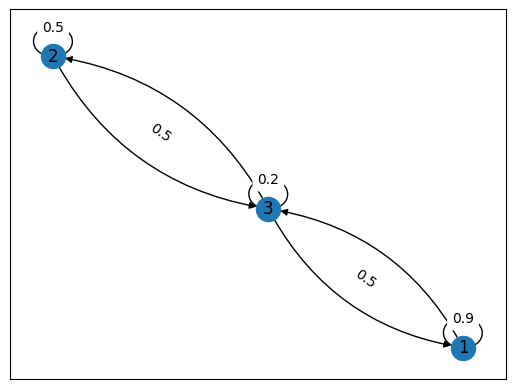

In [6]:
matrix2graph(m_probas);

Étudions maintenant de plus près la matrice $M$ et essayons de déterminer si cette dernière est :

- Strictement positive
- Irréductible
- Primitive

**Strictement positive**

$M$ n'est pas strictement positive, car $\forall i, j, M_{ij} \ngtr 0$.

**Irréductible**

$M$ est irréductible, car $\forall i, j, \exists k, (M^k)_{ij} > 0$. En effet, $M^2 \approx \begin{pmatrix}0.86 & 0.03 & 0.11\\0.25 & 0.40 & 0.35\\0.55 & 0.21 & 0.24\end{pmatrix}$.

**Primitive**

$M$ est primitive car $\exists k, \forall i, j, M_{ij} > 0$. En effet, $M^2 \approx \begin{pmatrix}0.86 & 0.03 & 0.11\\0.25 & 0.40 & 0.35\\0.55 & 0.21 & 0.24\end{pmatrix}$.

Si à un instant 0, le canal se trouve dans l'état parfait (1), quel sera le vecteur des probabilités à l'instant 3 ?

Soit $v_0 = \begin{pmatrix}1\\0\\0\end{pmatrix}$ le vecteur des probabilités à l'instant 0. Calculons maintenant le vecteur à l'instant 3 :

$$
    v_3^t = v_0^t * M^3 = \begin{pmatrix}1 & 0 & 0\end{pmatrix} * M^3 = \begin{pmatrix}1 & 0 & 0\end{pmatrix} * \begin{pmatrix}0.829 & 0.048 & 0.123\\0.400 & 0.305 & 0.295\\0.615 & 0.177 & 0.208\end{pmatrix} = \begin{pmatrix}0.829 & 0.048 & 0.123\end{pmatrix}
$$

Nous avons donc $v_3 = \begin{pmatrix}0.829\\0.048\\0.123\end{pmatrix}$ comme vecteur des probabilités à l'instant 3.

Nous allons maintenant calculer le vecteur propre de Perron-Frobenius.

Calculons $M^{10}$, $M^{20}$ et $M^{100}$ afin de vérifier la convergence de $M^k$.

In [7]:
print(f"M^10 = {np.linalg.matrix_power(m_probas, 10)}")
print(f"M^20 = {np.linalg.matrix_power(m_probas, 20)}")
print(f"M^100 = {np.linalg.matrix_power(m_probas, 100)}")

M^10 = [[0.76310406 0.08752139 0.14937455]
 [0.7275995  0.10881983 0.16358066]
 [0.74533418 0.09818117 0.15648465]]
M^20 = [[0.75734228 0.09097776 0.15167996]
 [0.75633365 0.09158282 0.15208353]
 [0.75683747 0.09128059 0.15188195]]
M^100 = [[0.75717381 0.09107882 0.15174737]
 [0.75717381 0.09107882 0.15174737]
 [0.75717381 0.09107882 0.15174737]]


Nous remarquons ici que $M^k$ converge et que les 3 vecteurs ligne ($M_{:1}$, $M_{:2}$, $M_{:3}$) composant $M^{100}$ sont identiques. Chacun de ces vecteurs correspond au vecteur propre de Perron-Frobenius.

## Génération aléatoire de l'état de canal

Nous allons maintenant réaliser un générateur aléatoire de l'état de canal.

Définissons une fonction permettant le passage d'une matrice stochastique $M$ à la matrice $P$ des probabilités cumulées. Cette dernière va faciliter la simulation de la chaîne de Markov, que nous allons réaliser grâce à deux autres fonctions.

In [8]:
def stochastic2cumulated(m: np.ndarray[float]) -> np.ndarray[float]:
    """Calcul de la matrice des probabilités cumulées à partir de la matrice stochastique.
    :param m: La matrice stochastique.
    :return: La matrice des probabilités cumulées.
    """
    cumu = np.zeros(np.shape(m), dtype=float)
    cumu[:, 0] = m[:, 0]
    for i in range(len(m)):
        for j in range(1,len(m)):
            #print(m[i, j])
            cumu[i, j] = m[i, j] + cumu[i, j-1]
    assert sum(cumu[:, -1]) == len(cumu)
    return cumu

def successeur(p: np.ndarray[float], i: int) -> int:
    """Renvoie le successeur de i, tiré à partir de la matrice des probabilités cumulées donnée.
    :param p: La matrice des probabilités cumulées.
    :param i: L'état de base.
    :return: Le successeur de i.
    """
    x = random.uniform(0, 1)
    j = 0
    while p[i - 1, j] < x:
        j += 1
    return j + 1

def random_gen(p: np.ndarray[float], init: int, n: int) -> str:
    """Génère aléatoirement une séquence de n états en partant de init, qui suit la matrice des probabilités donnée.
    :param p: La matrice des probabilités cumulées.
    :param init: L'état initial.
    :param n: Le nombre d'éléments de la séquence.
    :return: La chaîne de caractères correspondant à la séquence générée.
    """
    res = [init]
    for i in range(n):
        res.append(successeur(p, res[-1]))
    res = [str(x) for x in res]
    return "".join(res)

In [9]:
p_cumu = stochastic2cumulated(m_probas)

In [10]:
GEN_LENGTH = 100
gen_data = [int(elt) for elt in random_gen(p_cumu, 1, GEN_LENGTH)]
matrice_probas(gen_data)

array([[0.92405063, 0.        , 0.07594937],
       [0.        , 0.44444444, 0.55555556],
       [0.41666667, 0.5       , 0.08333333]])

In [11]:
GEN_LENGTH = 10000
PROXIMITY = .1

gen_data = [int(elt) for elt in random_gen(p_cumu, 1, GEN_LENGTH)]
gen_m_probas = matrice_probas(gen_data)
print(f"La matrice est bien estimée avec une proximité de {PROXIMITY} : {np.all(np.isclose(m_probas, gen_m_probas, PROXIMITY))}")

La matrice est bien estimée avec une proximité de 0.1 : True


L'estimation de $M$ ne dépend pas de la valeur init choisie car la valeur init est utilisée uniquement lors de la première itération.